In [136]:
from closure_funcs import *
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
import matplotlib.colors as mcolors
from scipy.stats import linregress

In [137]:
merged = pd.read_csv('../tables/merged_observed.csv')

In [138]:
merged = merged[np.logical_not((merged['Ice_Flag_2DS']==1) | (merged['ED-liquid_2DS']>=60E-6) | (merged['LWC_FCDP']>0.005) | (merged['N_CCN_stdPT'] < 50)) | (merged['ams_tot'] < 0.04)].reset_index(drop=True) #  

Remove negative AMS values

In [139]:
merged = merged[(merged['Org_Ave_IsoK_STP']>=0) & (merged['SO4_Ave_IsoK_STP']>=0) & (merged['NO3_Ave_IsoK_STP']>=0) & (merged['NH4_Ave_IsoK_STP']>=0) & (merged['Chl_Ave_IsoK_STP']>=0)]

Remove negative AMS values accept for Chl

In [140]:
#merged = merged[(merged['Org_Ave_IsoK_STP']>0) & (merged['SO4_Ave_IsoK_STP']>0) & (merged['NO3_Ave_IsoK_STP']>0) & (merged['NH4_Ave_IsoK_STP']>0)]

In [141]:
def calc_k(data, org_k, so4_k, no3_k, nh4_k, chl_k):
    d = data.copy()

    d['Org_vc'] = d['Org_Ave_IsoK_STP'] / 1000
    d['SO4_vc'] = d['SO4_Ave_IsoK_STP'] / 1770
    d['NO3_vc'] = d['NO3_Ave_IsoK_STP'] / 1770
    d['NH4_vc'] = d['NH4_Ave_IsoK_STP'] / 1770
    d['Chl_vc'] = d['Chl_Ave_IsoK_STP'] / 2200

    d['ams_tot_vc'] = d['Org_vc']+d['SO4_vc']+d['NO3_vc']+d['NH4_vc']+d['Chl_vc']

    d['k'] = org_k*d['Org_vc']/d['ams_tot_vc'] + so4_k*d['SO4_vc']/d['ams_tot_vc'] + no3_k*d['NO3_vc']/d['ams_tot_vc'] + nh4_k*d['NH4_vc']/d['ams_tot_vc'] + chl_k*d['Chl_vc']/d['ams_tot_vc']

    return d

In [142]:
def calc_k_theory(data, org_k = 0.14, so4_k = 0.507):
    d = data.copy()

    d['Org_vc'] = d['Org_Ave_IsoK_STP'] / 1000
    d['SO4_vc'] = d['SO4_Ave_IsoK_STP'] / 1770
    d['NO3_vc'] = d['NO3_Ave_IsoK_STP'] / 1770
    d['NH4_vc'] = d['NH4_Ave_IsoK_STP'] / 1770
    d['Chl_vc'] = d['Chl_Ave_IsoK_STP'] / 2200

    d['ams_tot_vc'] = d['Org_vc']+d['SO4_vc']+d['NO3_vc']+d['NH4_vc']+d['Chl_vc']

    d['k'] = org_k*d['Org_vc']/d['ams_tot_vc'] + so4_k*d['SO4_vc']/d['ams_tot_vc'] + 0.507*d['NO3_vc']/d['ams_tot_vc'] + 0.507*d['NH4_vc']/d['ams_tot_vc'] + 0.507*d['Chl_vc']/d['ams_tot_vc']

    return d

In [143]:
#merged = calc_k(merged, *[0.03697755, 0.03154126, 0.0921561 , 0.05973075, 0.84822169])#, org_k = .14, so4_k = .14)
merged['k'] = merged['k_obs'].median()#calc_k_theory(merged)
merged['k_obs'].median()

np.float64(0.03422259752252185)

In [144]:
# merged['k'].plot.hist(bins=80000)
# plt.xlim([-1,1])
# plt.xlabel('$\kappa$')
# plt.savefig('./figures/k_hist.png', dpi=300)

In [145]:
sub_m = merged[np.isfinite(merged['CCN_SS'])]#merged[(merged['k'] > 0) & (merged['k'] <= 1) & (np.isfinite(merged['CCN_SS']))]

In [146]:
sub_m_og = sub_m.copy()

In [147]:
sub_m = sub_m.copy().reset_index()
sub_m['D_c'] = np.nan
for i in tqdm(range(0,len(sub_m))):
    row = sub_m.iloc[i]
    #sub_m.loc[i, 'D_c'] = Dc_calculator(row['k'], row['CCN_SS'])
    #sub_m.loc[i, 'D_c'] = calculate_critical_diameter(row['k'], row['CCN_SS'])
    sub_m.loc[i, 'D_c'] = find_d_act(row['CCN_SS'], row['k'])

100%|██████████| 7641/7641 [00:02<00:00, 2751.00it/s]


In [148]:
sub_m = sub_m[np.logical_not(sub_m['D_c'].isna())]

Text(0.5, 0, '$\\kappa$')

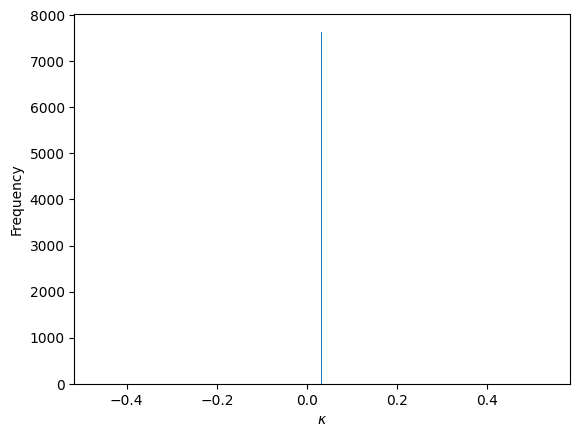

In [149]:
sub_m['k'].plot.hist(bins=250)
#plt.xlim([-1,1])
plt.xlabel(r'$\kappa$')
#plt.savefig('../figures/k_hist.png', dpi=300)

In [150]:
len(sub_m[np.isfinite(sub_m['k'])])

7641

In [151]:
sub_m['k'].describe()

count    7.641000e+03
mean     3.422260e-02
std      6.939348e-18
min      3.422260e-02
25%      3.422260e-02
50%      3.422260e-02
75%      3.422260e-02
max      3.422260e-02
Name: k, dtype: float64

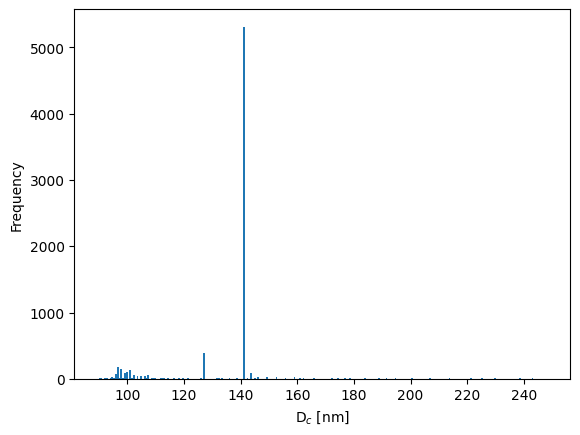

In [152]:
sub_m['D_c'].plot.hist(bins=250)
#plt.xlim([-1,1])
plt.xlabel('D$_c$ [nm]')
plt.savefig('../figures/Dc_hist_single.png', dpi=300)

In [153]:
sub_m['D_c'].describe()

count    7641.000000
mean      135.260458
std        19.900468
min        89.225899
25%       140.882886
50%       140.882886
75%       140.882886
max       248.465422
Name: D_c, dtype: float64

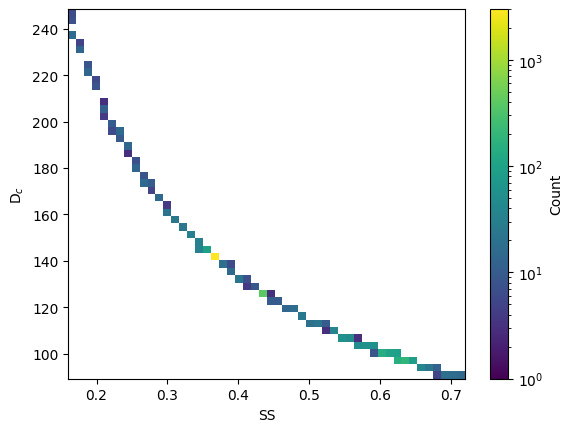

In [154]:
log_norm = mcolors.LogNorm(vmin=1, vmax=3000)

plt.hist2d(sub_m['CCN_SS'], sub_m['D_c'], bins=50, cmap='viridis', norm=log_norm)
plt.colorbar(label='Count', norm=log_norm)
plt.xlabel('SS')
plt.ylabel('D$_c$')
plt.savefig('../figures/D_c-SS_single.png', dpi=300)

In [155]:
bin_labels = ['SMPS_Bin02', 'SMPS_Bin03', 'SMPS_Bin04', 'SMPS_Bin05',
       'SMPS_Bin06', 'SMPS_Bin07', 'SMPS_Bin08', 'SMPS_Bin09', 'SMPS_Bin10',
       'SMPS_Bin11', 'SMPS_Bin12', 'SMPS_Bin13', 'SMPS_Bin14', 'SMPS_Bin15',
       'SMPS_Bin16', 'SMPS_Bin17', 'SMPS_Bin18', 'SMPS_Bin19', 'SMPS_Bin20',
       'SMPS_Bin21', 'SMPS_Bin22', 'SMPS_Bin23', 'SMPS_Bin24', 'SMPS_Bin25',
       'SMPS_Bin26', 'SMPS_Bin27', 'SMPS_Bin28', 'SMPS_Bin29', 'SMPS_Bin30', 'LAS_Bin01', 'LAS_Bin02', 'LAS_Bin03', 'LAS_Bin04', 'LAS_Bin05',
       'LAS_Bin06', 'LAS_Bin07', 'LAS_Bin08', 'LAS_Bin09', 'LAS_Bin10',
       'LAS_Bin11', 'LAS_Bin12', 'LAS_Bin13', 'LAS_Bin14', 'LAS_Bin15',
       'LAS_Bin16', 'LAS_Bin17', 'LAS_Bin18', 'LAS_Bin19', 'LAS_Bin20',
       'LAS_Bin21', 'LAS_Bin22', 'LAS_Bin23', 'LAS_Bin24', 'LAS_Bin25',
       'LAS_Bin26']

lower_bounds = [3.36, 3.76, 4.22, 4.74, 5.32, 5.97, 6.69, 7.51, 8.43, 9.46, 10.6, 11.9, 13.4, 15.0, 16.8, 18.9, 21.2, 23.8, 26.7, 29.9, 33.6, 37.6, 42.2, 47.4, 53.2, 59.7, 66.9, 75.1, 84.3, 93.9, 106.1, 119.0, 133.6, 149.9, 168.2, 188.7, 211.7, 237.5, 266.5, 299.0, 335.5, 376.5, 422.4, 473.9, 531.8, 596.6, 669.5, 751.1, 842.8, 945.6, 1129.5, 1421.9, 1790.1, 2253.6, 2837.1]
upper_bounds = [3.76, 4.22, 4.74, 5.32, 5.97, 6.69, 7.51, 8.43, 9.46, 10.6, 11.9, 13.4, 15.0, 16.8, 18.9, 21.2, 23.8, 26.7, 29.9, 33.6, 37.6, 42.2, 47.4, 53.2, 59.7, 66.9, 75.1, 84.3, 94.0, 106.1, 119.0, 133.6, 149.9, 168.2, 188.7, 211.7, 237.5, 266.5, 299.0, 335.5, 376.5, 422.4, 473.9, 531.8, 596.6, 669.5, 751.1, 842.8, 945.6, 1129.5, 1421.9, 1790.1, 2253.6, 2837.1, 3487.5]

dlogd=[]
for i in range(0,len(lower_bounds)):
       dlogd.append(np.log(upper_bounds[i]) - np.log(lower_bounds[i]))

In [156]:
sub_m2 = sub_m.copy()
sub_m2['CCN_n_pred'] = np.nan
bl_length = len(bin_labels)
#bin_pres_frac = []
for i in tqdm(range(0, len(sub_m2))):
    row = sub_m2.iloc[i]
    d_c = row['D_c']

    for j, ub in enumerate(upper_bounds):
        #print(lb)
        if d_c < ub:
            break
    
    bin_frac = (upper_bounds[j] - d_c) / (upper_bounds[j] - lower_bounds[j])

    count = 0
    if np.isfinite(row[bin_labels[j]]*bin_frac):
        sub_m2.loc[i, 'CCN_n_pred'] = row[bin_labels[j]]*bin_frac*dlogd[j]
        count+=1
    else:
        sub_m2.loc[i, 'CCN_n_pred'] = 0
    for k in range(j+1, bl_length):
        if np.isfinite(row[bin_labels[k]]):
            sub_m2.loc[i, 'CCN_n_pred'] += row[bin_labels[k]]*dlogd[k]
            count += 1
    if count/(bl_length-j) < .9:
        sub_m2.loc[i, 'CCN_n_pred'] = np.nan
    #bin_pres_frac.append(count/(bl_length-j))
sub_m2_og = sub_m2.copy()

100%|██████████| 7641/7641 [00:12<00:00, 592.01it/s]


In [157]:
sub_m2 = sub_m2[np.isfinite(sub_m2['CCN_n_pred'])]
sub_m2 = sub_m2[sub_m2['N_CCN_stdPT']>0]

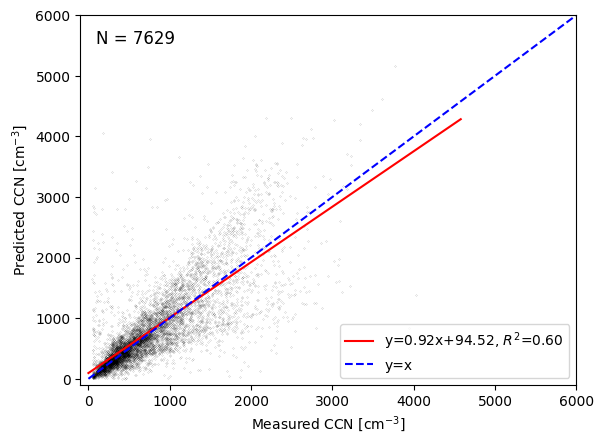

In [158]:
# Define the data
sub_m3 = sub_m2[sub_m2['N_CCN_stdPT']>50]
x = sub_m3['N_CCN_stdPT']
y = sub_m3['CCN_n_pred']
mask = ~np.isnan(x) & ~np.isnan(y)
num_points = np.sum(mask)

# Perform linear regression
slope, intercept, r_value, p_value, std_err = linregress(x, y)

# Calculate the line of best fit
fit_line = slope * np.linspace(0, x.max()) + intercept

# Plot the data and best fit line
plt.scatter(x, y, s=0.005, c='black')
plt.plot(np.linspace(0, x.max()), fit_line, c='r', label=f'y={slope:.2f}x+{intercept:.2f}, $R^2$={r_value**2:.2f}')
plt.plot(np.linspace(0, 6000), np.linspace(0, 6000), c='b', ls='--', label='y=x')
plt.xlim([-100, 6000])
plt.ylim([-100, 6000])
plt.ylabel('Predicted CCN [cm$^{-3}$]')
plt.xlabel('Measured CCN [cm$^{-3}$]')

plt.text(0.15, 0.85, f"N = {num_points}",
         fontsize=12, transform=plt.gcf().transFigure,
         verticalalignment='top', horizontalalignment='left')

plt.legend(loc='lower right')
plt.savefig('../figures/closure1_single.png', dpi=300)

In [159]:
d_group = sub_m3

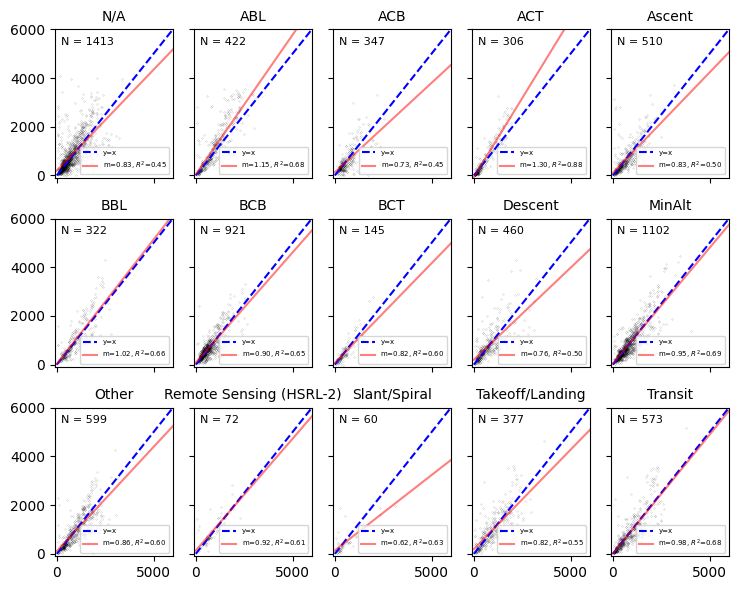

In [160]:
fig, axes = plt.subplots(3,5,figsize=(7.5, 6), sharex='all', sharey='all')
leg_labels = ['0', 'ABL', 'ACB', 'ACT', 'Ascent', 'BBL', 'BCB', 'BCT', 'Descent',
       'MinAlt', 'Other', 'Remote Sensing (HSRL-2)', 'Slant/Spiral',
       'Takeoff/Landing', 'Transit']
for i, ax in enumerate(axes.flatten()):
    if leg_labels[i] == '0':
        d_i = d_group[d_group['leg'].isna()]
    else:
        d_i = d_group[d_group['leg'] == leg_labels[i]]
    ax.scatter(d_i['N_CCN_stdPT'], d_i['CCN_n_pred'], s=0.005, c='black')
    ax.set_title(leg_labels[i], fontsize=10)
    ax.plot(np.linspace(0, 6000), np.linspace(0, 6000), c='b', ls='--', label='y=x')

    slope, intercept, r_value, p_value, std_err = linregress(d_i['N_CCN_stdPT'], d_i['CCN_n_pred'])
    # Calculate the line of best fit
    fit_line = slope * np.linspace(0, 6000) + intercept
    ax.plot(np.linspace(0, 6000), fit_line, c='r', label=f'm={slope:.2f}, $R^2$={r_value**2:.2f}', alpha=.5)
    ax.legend(fontsize=5, loc='lower right')
    mask = ~np.isnan(d_i['N_CCN_stdPT']) & ~np.isnan(d_i['CCN_n_pred'])
    num_points = np.sum(mask)
    ax.text(0.05, 0.95, f"N = {num_points}",
         fontsize=8, transform=ax.transAxes,
         verticalalignment='top', horizontalalignment='left')

axes[0,0].set_title('N/A', fontsize=10)
axes[0,0].set_xlim([-100, 6000])
axes[0,0].set_ylim([-100, 6000])
fig.tight_layout()
plt.savefig('../figures/all_legs_hor_single.png', dpi=300, bbox_inches='tight')